In [1]:
import argparse
import re
import time
from itertools import izip, cycle
import functools

import numpy as np
import Ska.DBI
from astropy.table import Table, vstack
from astropy.time import Time
import mica.archive.obspar
from mica.archive import asp_l1
import Ska.Shell
from Ska.quatutil import yagzag2radec
from Quaternion import Quat
from Ska.quatutil import radec2yagzag

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FIDS = {'ACIS-S': [1, 2, 3, 4, 5, 6],
        'ACIS-I': [1, 2, 3, 4, 5, 6],
        'HRC-I': [7, 8, 9, 10],
        'HRC-S': [11, 12, 13, 14],
        }


In [3]:
# Nominal SIM focus positions -- FIX ME
sim_x_nom = {'ACIS-S': -0.68,
            'ACIS-I': -0.68,
            'HRC-S': -0.68,
            'HRC-I': -0.68}

In [4]:
aimpoint_data_cache = {}
acis_pixscale = 0.492  # arcsec / pixel

def get_aimpoint_data(det):
    """
    Read aimpoint data provided by P. Zhao and define additional columns
    that make it easier to compare with fid light drift data.
    """
    if det not in aimpoint_data_cache:
        filename = 'optics_aimpoint/{}_ap_pos.rdb'.format(re.sub(r'-', '', det).lower())
        dat = Table.read(filename, format='ascii.rdb')
        y_off = dat['y_det_offset'] * 60 / acis_pixscale  # pix / arcmin
        z_off = dat['z_det_offset'] * 60 / acis_pixscale  # pix / arcmin

        aimpoint_data_cache[det] = dat
    return aimpoint_data_cache[det]    

In [5]:
def get_zero_offset_aimpoint_data(det, min_year=2010):
    """
    Return aimpoint data for observations with zero target offset.
    This simplifies the correlation of aspect solution and dmcoords
    results with the published POG plots (chapter 4) of aimpoint drift.
    """
    dat = get_aimpoint_data(det)
    ok = (dat['y_det_offset'] == 0) & (dat['z_det_offset'] == 0) & (dat['year'] > min_year)
    return dat[ok]

In [6]:
dats = get_zero_offset_aimpoint_data('ACIS-S', 2010)
dati = get_zero_offset_aimpoint_data('ACIS-I', 2010)
hrcs = get_zero_offset_aimpoint_data('HRC-S', 2010)
hrci = get_zero_offset_aimpoint_data('HRC-I', 2010)

observations = vstack([dats, dati, hrcs, hrci])

In [7]:
dats[-5:]

obsid,ra_targ,dec_targ,sim_z,sim_z_offset,y_det_offset,z_det_offset,dmt_chipx,dmt_chipy,ap_chipx,ap_chipy,year
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
15699.0,283.6127,-20.1692,-190.14006605,0.00754346686406,0.0,0.0,337.38,585.27,337.38,584.96,2014.152054
18144.0,243.488333,65.719444,-190.14006605,0.00754346686406,0.0,0.0,201.73,477.22,201.73,476.91,2016.213742
18145.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,199.94,477.1,199.94,476.68,2016.21851
18799.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,196.99,475.36,196.99,474.94,2016.221493
18814.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,198.31,476.16,198.31,475.74,2016.215901


In [8]:
# Define nominal SIM-X and Z positions as median observed values

sim_z_nom = {'ACIS-S': np.median(dats['sim_z']),
             'ACIS-I': np.median(dati['sim_z']),
             'HRC-S': np.median(hrcs['sim_z']),
             'HRC-I': np.median(hrci['sim_z'])}
sim_z_nom

{'ACIS-I': -233.58743446082869,
 'ACIS-S': -190.14258036517339,
 'HRC-I': 126.98297998998621,
 'HRC-S': 250.46603308020099}

In [9]:
# Use the obspar for each obsid to fill in some additional
# columns.  Yag and Zag represent the local frame position
# (arcsec) of the target in the nominal frame.

noms = ('ra_nom', 'dec_nom', 'roll_nom')
for nom in noms:
    observations[nom] = 0.0
observations['yag'] = 0.0
observations['zag'] = 0.0
observations['ra_pnt'] = 0.0
observations['dec_pnt'] = 0.0
observations['detector'] = 'ACIS-S'

for obs in observations:
    obspar = mica.archive.obspar.get_obspar(obs['obsid'])
    for nom in noms:
        obs[nom] = obspar[nom]
    obs['ra_targ'] = obspar['ra_targ']
    obs['dec_targ'] = obspar['dec_targ']
    obs['ra_pnt'] = obspar['ra_pnt']
    obs['dec_pnt'] = obspar['dec_pnt']
    obs['detector'] = obspar['detector']
    q_nom = Quat([obs[nom] for nom in noms])
    obs['yag'], obs['zag'] = radec2yagzag(obspar['ra_targ'], obspar['dec_targ'], q_nom)

observations['yag'] *= 3600
observations['zag'] *= 3600

In [10]:
ok = observations['detector'] == 'HRC-I'
observations[ok][:10]

obsid,ra_targ,dec_targ,sim_z,sim_z_offset,y_det_offset,z_det_offset,dmt_chipx,dmt_chipy,ap_chipx,ap_chipy,year,ra_nom,dec_nom,roll_nom,yag,zag,ra_pnt,dec_pnt,detector
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string48
10980.0,219.880833,-60.833611,126.98297999,0.00250890161531,0.0,0.0,7615.16,7876.76,7615.44,7877.04,2010.337018,219.889088992,-60.8351886006,0.206532993812,-14.4641698335,5.73062688131,219.889088992,-60.8351886006,HRC-I
10981.0,219.880833,-60.833611,126.98297999,0.00250890161531,0.0,0.0,7638.94,7834.59,7639.22,7834.87,2010.809946,219.871931629,-60.8332280321,196.582490367,-14.5737317164,5.77938669305,219.871931629,-60.8332280321,HRC-I
11808.0,10.684583,41.269278,126.98297999,0.00250890161531,0.0,0.0,7635.66,7878.25,7635.94,7878.53,2010.129265,10.6868073077,41.265356803,314.832594874,-14.2542449954,5.68438598704,10.6868073077,41.265356803,HRC-I
11809.0,10.684583,41.269278,126.98297999,0.00250890161531,0.0,0.0,7628.63,7855.13,7628.91,7855.41,2010.157781,10.6874732103,41.2655837895,322.265559712,-14.3240081833,5.73171324704,10.6874732103,41.2655837895,HRC-I
11819.0,125.489583,-43.004361,126.98297999,0.00250890161531,0.0,0.0,7629.57,7878.69,7629.85,7878.97,2010.611007,125.485042345,-43.0017377626,163.423426592,-14.1516322839,5.64101063257,125.485042345,-43.0017377626,HRC-I
11826.0,83.866667,-69.269778,126.985494305,-5.41368623885e-06,0.0,0.0,7628.62,7848.94,7628.62,7848.94,2010.631347,83.8639574792,-69.2656814583,124.901975371,-14.0705501101,5.60653768138,83.8639574792,-69.2656814583,HRC-I
11889.0,332.17,45.742306,126.98297999,0.00250890161531,0.0,0.0,7613.93,7852.01,7614.21,7852.29,2010.73513,332.164330909,45.7411506149,218.755646471,-13.7110923068,5.67213116934,332.164330909,45.7411506149,HRC-I
11934.0,199.092083,29.099,126.98297999,0.00250890161531,0.0,0.0,7623.78,7839.79,7624.06,7840.07,2010.219691,199.090202789,29.1029448925,136.905535769,-14.0214251323,6.32964086233,199.090202789,29.1029448925,HRC-I
11940.0,279.235,38.783778,126.985494305,-5.41368623885e-06,0.0,0.0,7626.24,7856.86,7626.24,7856.86,2010.291473,279.23564536,38.7880756891,107.000625911,-14.2660694138,6.25554583972,279.23564536,38.7880756891,HRC-I


In [11]:
observations

obsid,ra_targ,dec_targ,sim_z,sim_z_offset,y_det_offset,z_det_offset,dmt_chipx,dmt_chipy,ap_chipx,ap_chipy,year,ra_nom,dec_nom,roll_nom,yag,zag,ra_pnt,dec_pnt,detector
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string48
12351.0,134.773333,-47.511361,-190.142580365,0.0100577821656,0.0,0.0,213.15,481.91,213.15,481.49,2010.749869,134.772517852,-47.5069751289,118.669699202,-14.8043348396,5.83588751136,134.772517852,-47.5069751289,ACIS-S
12360.0,217.403933,-62.677144,-190.142580365,0.0100577821656,0.0,0.0,217.53,482.22,217.53,481.8,2010.952011,217.401795404,-62.6728281746,124.354134058,-14.8200754265,5.85158637411,217.401795404,-62.6728281746,ACIS-S
15699.0,283.6127,-20.1692,-190.14006605,0.00754346686406,0.0,0.0,337.38,585.27,337.38,584.96,2014.152054,283.596333638,-20.1466612318,93.4326778771,-84.3081866603,-50.3482344509,283.596333638,-20.1466612318,ACIS-S
18144.0,243.488333,65.719444,-190.14006605,0.00754346686406,0.0,0.0,201.73,477.22,201.73,476.91,2016.213742,243.493434519,65.7208733936,105.151971758,-2.99269562581,8.63437072007,243.493434519,65.7208733936,ACIS-S
18145.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,199.94,477.1,199.94,476.68,2016.21851,243.493480326,65.7208625844,105.151925759,-2.93741258254,8.68964818806,243.493480326,65.7208625844,ACIS-S
18799.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,196.99,475.36,196.99,474.94,2016.221493,243.493444934,65.7208819429,105.151946389,-3.0183759657,8.65729426372,243.493444934,65.7208819429,ACIS-S
18814.0,243.488333,65.719444,-190.142580365,0.0100577821656,0.0,0.0,198.31,476.16,198.31,475.74,2016.215901,243.49349518,65.7208942328,105.151903918,-3.04164029261,8.74065114484,243.49349518,65.7208942328,ACIS-S
11613.0,39.300417,-25.426611,-233.587434461,-0.005018542101,0.0,0.0,933.74,997.64,933.95,997.64,2010.801175,39.3056137487,-25.4263016358,25.206436069,-15.7617197746,6.18778115069,39.3056137487,-25.4263016358,ACIS-I
11625.0,149.894583,-5.363611,-233.587434461,-0.005018542101,0.0,0.0,936.2,997.74,936.41,997.74,2010.093325,149.899269411,-5.36277802322,31.4488651615,-15.8943796702,6.20545496733,149.899269411,-5.36277802322,ACIS-I


In [12]:
# Look at key columns for the first few obsids

observations[('obsid', 'ra_targ', 'dec_targ') +
             ('ra_pnt', 'dec_pnt') +
             noms + ('yag', 'zag')][:5]

obsid,ra_targ,dec_targ,ra_pnt,dec_pnt,ra_nom,dec_nom,roll_nom,yag,zag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
12351.0,134.773333,-47.511361,134.772517852,-47.5069751289,134.772517852,-47.5069751289,118.669699202,-14.8043348396,5.83588751136
12360.0,217.403933,-62.677144,217.401795404,-62.6728281746,217.401795404,-62.6728281746,124.354134058,-14.8200754265,5.85158637411
15699.0,283.6127,-20.1692,283.596333638,-20.1466612318,283.596333638,-20.1466612318,93.4326778771,-84.3081866603,-50.3482344509
18144.0,243.488333,65.719444,243.493434519,65.7208733936,243.493434519,65.7208733936,105.151971758,-2.99269562581,8.63437072007
18145.0,243.488333,65.719444,243.493480326,65.7208625844,243.493480326,65.7208625844,105.151925759,-2.93741258254,8.68964818806


In [13]:
def plot_yag_zag(observations, det):
    """
    Plot the local target position in Yag, Zag coordinates
    (referenced to the nominal frame).
    """
    ok = observations['detector'] == det
    plt.plot(observations['yag'][ok], observations['zag'][ok], '.')
    plt.xlim(-18, -12)
    plt.ylim(4, 8)
    plt.grid()
    plt.title(det)
    plt.ylabel('zag (arcsec)')
    plt.xlabel('yag (arcsec)')

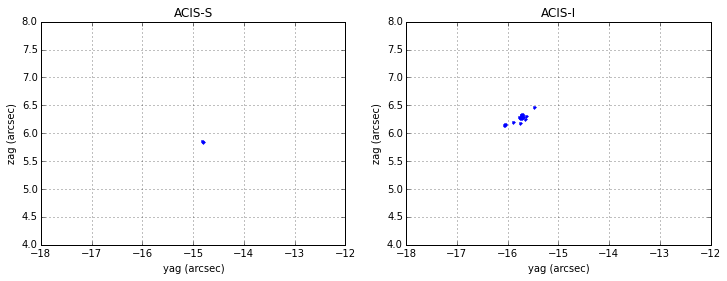

In [14]:
# Now we are convinced that there is a predictable offset
# between the target coordinate and the nominal frame.

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_yag_zag(observations, 'ACIS-S')
plt.subplot(1, 2, 2)
plot_yag_zag(observations, 'ACIS-I')


In [15]:
# Define a fake nominal frame as ra, dec, roll = 0.
# Then define a "zero" target location ra0, dec0 that has
# the same Yag, Zag values 

q0 = Quat([0, 0, 0])
ra0, dec0 = -15.5 / 3600., 6.0 / 3600.
np.array(radec2yagzag(ra0, dec0, q0)) * 3600.

array([-15.5       ,   6.00000002])

### Where does this -15, 6 arcsec offset come from?

It's basically the difference between two rotation matrices in our system:

- `ACA_MISALIGN`: MNC (HRMA optical axis) to ACA frame misalignment.
- `ODB_SI_ALIGN`: Misalignment used to transform from science target coordinates to ACA (PCAD) pointing direction that gets used on-board.

My recollection is that the fact that these are not the same is a relic of a decision during OAC, but I'm not entirely certain of that.

In [16]:

calalign = Table.read('/soft/ciao/CALDB/data/chandra/pcad/align/pcadD2012-09-13alignN0009.fits',
                     hdu='CALALIGN')

In [17]:
calalign

INSTR_ID,"ACA_SC_ALIGN [3,3]","ACA_MISALIGN [3,3]","FTS_MISALIGN [3,3]",LSI0_STT [3],RRC0_FC_X
,,,,mm,mm
string72,float64,float64,float64,float64,float64
ACIS-S,1.0 .. 1.0,0.999999885766 .. 0.999996233612,0.999999987092 .. 0.999995726325,0.0 .. 190.5,10065.5117188
ACIS-I,1.0 .. 1.0,0.999999884457 .. 0.999993337636,0.99999998528 .. 0.999989507649,0.0 .. 237.4,10065.5117188
HRC-S,1.0 .. 1.0,0.999999873574 .. 0.999999272401,0.99999998383 .. 0.99999703533,0.0 .. -250.1,10065.5117188
HRC-I,1.0 .. 1.0,0.999999886877 .. 0.999998580823,0.999999980036 .. 0.999996258348,0.0 .. -126.6,10065.5117188


In [18]:
# ACIS-S misalign in arcsec (pay attention to elements in row 0, columns 1 & 2)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][0][0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -84.76 arcsec, dz = -50.36 arcsec


In [19]:
# ACIS-I misalign in arcsec (pay attention to elements in row 0, columns 1 & 2)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][1][0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -85.73 arcsec, dz = -49.82 arcsec


### Residual of ACA_MISALIGN * ODB_SI_ALIGN matches observed Yag, Zag values!

(Reasonably well).

In [20]:
ODB_SI_ALIGN  = np.array([[1.0, 3.3742E-4, 2.7344E-4],                    
                          [-3.3742E-4, 1.0, 0.0],          
                          [-2.7344E-4, 0.0, 1.0]])

In [21]:
# ACA_MISALIGN * ODB_SI_ALIGN delta alignment (ACIS-S)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][0].dot(ODB_SI_ALIGN)[0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -15.16 arcsec, dz = 6.04 arcsec


In [22]:
# ACA_MISALIGN * ODB_SI_ALIGN delta alignment (ACIS-I)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][1].dot(ODB_SI_ALIGN)[0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -16.13 arcsec, dz = 6.58 arcsec


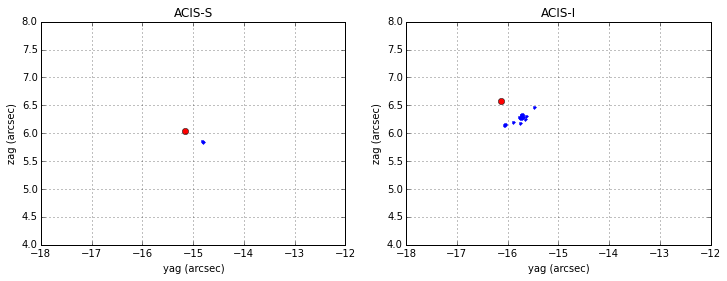

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_yag_zag(observations, 'ACIS-S')
plt.plot([-15.16], [6.04], 'or')
plt.subplot(1, 2, 2)
plot_yag_zag(observations, 'ACIS-I')
plt.plot([-16.13], [6.58], 'or')


### Use dmcoords to relate detector, dy, dz to chipx, chipy

This will be an approximation that applies over small displacements (of order 100 pixels).

In [24]:
ciaoenv = Ska.Shell.getenv('source /soft/ciao/bin/ciao.sh')

In [25]:
dmcoords_cmd = ['dmcoords', 'none',
                'asolfile=none',
                'detector="{detector}"',
                'opt=cel',
                'ra={ra}', 
                'dec={dec}',
                'celfmt=deg', 
                'ra_nom=0',
                'dec_nom=0',
                'roll_nom=0',  
                'ra_asp=")ra_nom"',
                'dec_asp=")dec_nom"',
                'roll_asp=")roll_nom"',      
                'sim="{simx} 0 {simz}"',
                'displace="0 {dy} {dz} 0 0 0"',       
                'verbose=0']
dmcoords_cmd = ' '.join(dmcoords_cmd)

In [26]:
ciaorun = functools.partial(Ska.Shell.bash, env=ciaoenv)

In [96]:
def dmcoords_chipx_chipy(det, dy, dz):
    """
    Get the dmcoords-computed chipx and chipy for given detector and
    aspect solution DY and DZ values.  NOTE: the ``dy`` and ``dz`` inputs
    to dmcoords are flipped in sign from the ASOL values.  Generally the
    ASOL DY/DZ are positive and dmcoord input values are negative.  This
    sign flip is handled *here*, so input to this is ASOL DY/DZ.
    
    :param det: detector (ACIS-S, ACIS-I, HRC-S, HRC-I)
    :param dy: aspect solution DY value (mm)
    :param dz: aspect solution DZ value (mm)
    """
    ra0, dec0 = -15.5 / 3600., 6.0 / 3600.
    ciaorun('punlearn dmcoords')
    cmd = dmcoords_cmd.format(ra=ra0, dec=dec0,
                                detector=(det if det.startswith('HRC') else 'ACIS'),
                                simx=sim_x_nom[det], simz=sim_z_nom[det],
                                dy=-dy, dz=-dz)
    print(cmd)
    ciaorun(cmd)
    return [float(x) for x in ciaorun('pget dmcoords chipx chipy chip_id')]

In [28]:
def get_dy_dz(obsid):
    asolfiles = asp_l1.get_files(obsid=obsid, content=['ASPSOL'])
    asol = Table.read(asolfiles[0])
    min_dy, median_dy, max_dy = (np.min(asol['dy']), 
                              np.median(asol['dy']),
                              np.max(asol['dy']))
    min_dz, median_dz, max_dz = (np.min(asol['dz']), 
                              np.median(asol['dz']),
                              np.max(asol['dz']))
    return min_dy, median_dy, max_dy, min_dz, median_dz, max_dz                                 

In [92]:
dmcoords_chipx_chipy('HRC-I', 0, 0)

dmcoords none asolfile=none detector="HRC-I" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 126.98297999" displace="0 0 0 0 0 0" verbose=0


[-9830.77011598587, 7730.981441112255, 0.0]

In [30]:
dati['obsid', 'year'][:4]

obsid,year
float64,float64
11613.0,2010.801175
11625.0,2010.093325
11629.0,2010.095863
11637.0,2010.096049


In [95]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(5480)
print dmcoords_chipx_chipy(det='ACIS-I', dy=median_dy, dz=median_dz)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -0.420609921217 -0.598723948002 0 0 0" verbose=0
[946.9212165278603, 980.6656784373248, 3.0]


In [35]:
dats['obsid', 'year'][:4]

obsid,year
float64,float64
12351.0,2010.749869
12360.0,2010.952011
15699.0,2014.152054
18144.0,2016.213742


In [36]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(6730)
print dmcoords_chipx_chipy(det='ACIS-S', dy=median_dy, dz=median_dz)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -190.142580365" displace="0 -0.436500787735 -0.647037029266 0 0 0" verbose=0
[234.0630026018012, 493.0024392046939, 7.0]


### DY and DZ correspond to adding values to Y_A and Z_A

<img src="http://cxc.harvard.edu/proposer/POG/html/images/simc.png">

In [97]:
dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=-10.0)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 10.0 10.0 0 0 0" verbose=0


[342.3181282064434, 545.2645632588228, 1.0]

In [98]:
dmcoords_chipx_chipy(det='ACIS-I', dy=10.0, dz=10.0)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -10.0 -10.0 0 0 0" verbose=0


[470.7569583523996, 690.4237024391731, 2.0]

In [99]:
dmcoords_chipx_chipy(det='ACIS-I', dy=10.0, dz=-10.0)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -10.0 10.0 0 0 0" verbose=0


[682.2762748605664, 690.5169906148068, 0.0]

In [100]:
dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=10.0)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 10.0 -10.0 0 0 0" verbose=0


[554.5065731372622, 544.7118661806131, 3.0]

In [46]:
def xform(pars, x):
    c0x, c0y, cyx, czx, cyy, czy = pars
    c0 = np.array([[c0x],
                   [c0y]])
    cyz = np.array([[cyx, czx],
                    [cyy, czy]])
    x = np.array(x).reshape(-1, 2).transpose()
    y = c0 + cyz.dot(x)
    return y.transpose().flatten()

In [47]:
pars = [971.91, 963.07, 0.0, +41.74, -41.74, 0.0]
x = [-1, -1, 0, -1, -1, -2.0]
# x = [-1, -1]
print xform(pars, x)

[  930.17  1004.81   930.17   963.07   888.43  1004.81]


In [48]:
from sherpa import ui
import logging
logging.disable(50)

In [76]:
def fit_xform(det, chip_id, dy0, dz0):
    det = det.upper()
    x = []
    y = []
    for ddy, ddz in ((0, 0), (1, 0), (0, 1)):
        dy = dy0 + ddy
        dz = dz0 + ddz
        cx, cy, cid = dmcoords_chipx_chipy(det, dy, dz)
        if cid != chip_id:
            raise ValueError('Chip mismatch {} != {}'.format(cid, chip_id))
        x.extend([dy, dz])
        y.extend([cx, cy])
    ui.load_arrays(1, np.array(x), np.array(y))
    ui.load_user_model(xform, 'xform_mdl')
    ui.add_user_pars('xform_mdl', ['c0x', 'c0y', 'cyx', 'czx', 'cyy', 'czy'])
    ui.set_model(xform_mdl)
    ui.fit()
    
    return ui.get_fit_results()

In [101]:
fr = fit_xform('ACIS-I', 3, 0.0, 0.0)

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -0.0 -0.0 0 0 0" verbose=0
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -1.0 -0.0 0 0 0" verbose=0
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -0.0 -1.0 0 0 0" verbose=0


In [103]:
fr.parvals

(971.91338185545169,
 963.17127135867679,
 -0.0010007356321284501,
 -41.741681607451795,
 41.741548160198207,
 -0.10439235760838411)

In [52]:
fr = fit_xform(det='HRC-I', chip_id=0, dy0=0.0, dz0=0.0)

dmcoords none asolfile=none detector="HRC-I" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 126.98297999" displace="0 0.0 0.0 0 0 0" verbose=0
dmcoords none asolfile=none detector="HRC-I" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 126.98297999" displace="0 1.0 0.0 0 0 0" verbose=0
dmcoords none asolfile=none detector="HRC-I" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 126.98297999" displace="0 0.0 1.0 0 0 0" verbose=0


In [53]:
fr.parvals

(-9830.7701159858698,
 7730.9814411122552,
 109.98021295500075,
 -109.98021295782792,
 -109.98021295713124,
 -109.98021295713124)

In [104]:
xforms = {}

In [105]:
det_ids = (('acis-i', 3, 0, 0),
          ('acis-i', 0, 10, -10),
          ('acis-i', 1, -10, -10),
          ('acis-i', 2, 10, 10),
          ('acis-s', 7, 0, 0),
          ('acis-s', 6, 25, 0),
          ('acis-s', 5, 50, 0),
          ('acis-s', 4, 75, 0),
          ('acis-s', 8, -25, 0),
          ('acis-s', 9, -50, 0))

In [106]:
for det, chip_id, dy0, dz0 in det_ids:
    key = det.upper(), chip_id
    if key in xforms:
        continue
    fr = fit_xform(det, chip_id, dy0, dz0)
    xforms[key] = fr.parvals

dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 0 0 0 0 0" verbose=0
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -1 0 0 0 0" verbose=0
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 0 -1 0 0 0" verbose=0
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 -10

In [107]:
print xform(xforms['ACIS-I', 1], [-10, -10])
print dmcoords_chipx_chipy(det='ACIS-I', dy=-10.0, dz=-10.0)

[ 342.31812821  545.26456326]
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -233.587434461" displace="0 10.0 10.0 0 0 0" verbose=0
[342.3181282064434, 545.2645632588228, 1.0]


In [108]:
print xform(xforms['ACIS-S', 7], [0, 0])
print dmcoords_chipx_chipy(det='ACIS-S', dy=0.0, dz=0.0)

[ 252.27470319  519.96727988]
dmcoords none asolfile=none detector="ACIS" opt=cel ra=-0.00430555555556 dec=0.00166666666667 celfmt=deg ra_nom=0 dec_nom=0 roll_nom=0 ra_asp=")ra_nom" dec_asp=")dec_nom" roll_asp=")roll_nom" sim="-0.68 0 -190.142580365" displace="0 -0.0 -0.0 0 0 0" verbose=0
[252.2747031852626, 519.9672798776261, 7.0]


In [110]:
xforms_out = {}
for key, val in xforms.items():
    vals = [round(x, 3) for x in val]
    xforms_out[key] = {'c0': [vals[0], vals[1]],
                      'cyz': [[vals[2], vals[3]],
                              [vals[4], vals[5]]]}

In [111]:
from pprint import pprint
pprint(xforms_out)

{('ACIS-I', 0): {'c0': [1099.688, 1108.984],
                 'cyz': [[0.001, 41.742], [-41.742, 0.105]]},
 ('ACIS-I', 1): {'c0': [-75.089, 963.721],
                 'cyz': [[0.001, -41.742], [41.741, 0.104]]},
 ('ACIS-I', 2): {'c0': [53.349, 1108.888],
                 'cyz': [[-0.001, 41.742], [-41.742, -0.105]]},
 ('ACIS-I', 3): {'c0': [971.913, 963.171],
                 'cyz': [[-0.001, -41.742], [41.742, -0.104]]},
 ('ACIS-S', 4): {'c0': [3383.032, 520.173],
                 'cyz': [[-41.695, -0.021], [0.021, -41.689]]},
 ('ACIS-S', 5): {'c0': [2339.627, 519.299],
                 'cyz': [[-41.691, -0.031], [0.037, -41.689]]},
 ('ACIS-S', 6): {'c0': [1296.718, 519.682],
                 'cyz': [[-41.69, -0.031], [0.036, -41.689]]},
 ('ACIS-S', 7): {'c0': [252.275, 519.967],
                 'cyz': [[-41.689, -0.022], [0.022, -41.689]]},
 ('ACIS-S', 8): {'c0': [-789.536, 519.933],
                 'cyz': [[-41.69, -0.02], [0.02, -41.689]]},
 ('ACIS-S', 9): {'c0': [-1831.755, 519.